<a href="https://colab.research.google.com/github/Ksenyff/ICV-2024/blob/main/%D0%A1%D0%BF%D0%B8%D1%80%D0%B8%D0%B4%D0%BE%D0%BD%D0%BE%D0%B2%D0%B0%D0%9A.%D0%9E_%D0%94%D0%972_%D0%B2%D0%B8%D0%B4%D0%B5%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2. Ball Tracking

In [ ]:
import cv2
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Trajectory generation
from scipy.interpolate import interp1d, CubicSpline

# Display video (embedded)
from IPython.display import Video

## Video Generation and Helpers

Converting video into MP4 format for visualization in Google Colab:

In [ ]:
convert_avi2mp4="""echo "Converting '{input}' to '{output}'..." && \
                   ffmpeg -y -i {input} -c:v libx264 -preset veryslow -crf 18 -an -hide_banner -loglevel error {output} && \
                   echo 'Completed.'"""

**Bonus task** (5 points): explain what is written in the command above.

**Answer**: Данная команда выполняет конвертацию видеофайла из формата AVI в формат MP4 с использованием заданных параметров качества и кодирования.

In [ ]:
def interpolate_trajectory(waypoints, num_points, kind='linear'):
  """
  Generates a smooth trajectory using linear or cubic spline interpolation
  based on input waypoints for pixel coordinates.

  Parameters:
    waypoints (list of tuples): List of (x, y) waypoints.
    num_points (int): Total number of interpolated points to generate.
    kind (str): Type of interpolation. Options: 'linear', 'cubic'.

  Returns:
    np.ndarray: Array of interpolated (x, y) coordinates.
  """
  # Extract x and y coordinates
  num_waypoints = len(waypoints)
  t = np.linspace(0, 1, num_waypoints)  # Normalized parameter for waypoints

  x_coords = [point[0] for point in waypoints]
  y_coords = [point[1] for point in waypoints]

  # Generate interpolated points
  t_fine = np.linspace(0, 1, num_points)  # Fine-grained parameter for trajectory

  if kind == 'linear':
    x_interpolator = interp1d(t, x_coords, kind='linear')
    y_interpolator = interp1d(t, y_coords, kind='linear')
    interpolated_x = x_interpolator(t_fine)
    interpolated_y = y_interpolator(t_fine)
  elif kind == 'cubic':
    cs_x = CubicSpline(t, x_coords)
    cs_y = CubicSpline(t, y_coords)
    interpolated_x = cs_x(t_fine)
    interpolated_y = cs_y(t_fine)
  else:
    raise ValueError("Invalid 'kind'. Supported options: 'linear', 'cubic'.")

  # Combine into trajectory (x, y) coordinates
  trajectory = np.vstack((interpolated_x, interpolated_y)).T
  return trajectory.astype(np.float32)

**Bonus task** (5 points): explain the 22nd line of the code above. What is `t` and `t_fine`?


t: Нормализованный параметр для точек маршрута. t отвечает за местоположение каждой точки маршрута в нормализованном пространстве;

t_fine: Нормализованные параметры, используемые для генерации плотного набора интерполированных точек вдоль траектории. t_fine используется для указания позиций, в которых необходимо оценить интерполированную траекторию, что приводит к плавному переходу между точками маршрута.

In [ ]:
def generate_square_waypoints(center, side_length):
  """
  Generates waypoints forming a square trajectory.

  Parameters:
    center (tuple): (x, y) coordinates of the square's center.
    side_length (int): Length of each side of the square.
    num_points (int): Number of waypoints per side (default: 4).

  Returns:
    list of tuples: List of (x, y) waypoints forming the square.
  """
  half_side = side_length / 2

  # Define the four corners of the square
  top_left = (center[0] - half_side, center[1] - half_side)
  top_right = (center[0] + half_side, center[1] - half_side)
  bottom_right = (center[0] + half_side, center[1] + half_side)
  bottom_left = (center[0] - half_side, center[1] + half_side)

  return [top_left, top_right, bottom_right, bottom_left, top_left]

In [ ]:
def compute_mse(gt_trajectory, detected_trajectory):
    """
    Compute the Mean Squared Error (MSE) between the ground truth
    and detected trajectories.

    Parameters:
        gt_trajectory (list of tuples or np.ndarray): Ground truth trajectory as (x, y) coordinates.
        detected_trajectory (list of tuples or np.ndarray): Detected trajectory as (x, y) coordinates.

    Returns:
        float: Mean Squared Error between the two trajectories.
    """
    # Convert input trajectories to NumPy arrays for efficient computation
    gt_trajectory = np.array(gt_trajectory)
    detected_trajectory = np.array(detected_trajectory)

    # Calculate squared differences between corresponding points
    squared_differences = (gt_trajectory - detected_trajectory) ** 2

    # Compute the mean of squared differences (mean over both x and y)
    mse = np.mean(squared_differences)
    return mse


def compute_rmse(gt_trajectory, detected_trajectory):
    """
    Compute the Root Mean Squared Error (RMSE) between the ground truth
    and detected trajectories.

    Parameters:
        gt_trajectory (list of tuples or np.ndarray): Ground truth trajectory as (x, y) coordinates.
        detected_trajectory (list of tuples or np.ndarray): Detected trajectory as (x, y) coordinates.

    Returns:
        float: Root Mean Squared Error between the two trajectories.
    """
    return np.sqrt(compute_mse(gt_trajectory, detected_trajectory))

In [ ]:
def add_cross_noise(frame, noise_count, cross_color=(255, 255, 255)):
  """
  Adds random cross-shaped noise to a BGR image.

  Parameters:
    frame (np.ndarray): The input BGR image where noise is added.
    noise_count (int): Number of cross-shaped noise elements to add.
    cross_color (tuple): Color of the noise as a (B, G, R) tuple (default is white).

  Returns:
    np.ndarray: BGR image with cross-shaped noise added.
  """
  # Get image dimensions
  height, width, _ = frame.shape

  # Generate noise
  for _ in range(noise_count):
    # Randomly choose a central position for the cross
    center_x = random.randint(1, width - 2)
    center_y = random.randint(1, height - 2)

    # Add cross-shaped noise (center and four neighbors)
    frame[center_y, center_x] = cross_color  # Center
    frame[center_y - 1, center_x] = cross_color  # Top
    frame[center_y + 1, center_x] = cross_color  # Bottom
    frame[center_y, center_x - 1] = cross_color  # Left
    frame[center_y, center_x + 1] = cross_color  # Right

  return frame

In [ ]:
def generate_video(output_file, trajectory, framerate,
                   frame_width=500, frame_height=500,
                   bg_color=(0, 0, 0), enable_cross_noise=False,
                   ball_radius=32, ball_color=(0, 0, 255)):
  """
  Generates a video with a moving ball based on a given trajectory.

  Parameters:
    output_file (str): Path to save the generated video file.
    trajectory (list of tuples): A list of (x, y) coordinates for the ball's center.
    framerate (int): Frames per second for the output video.
    frame_width (int): Width of each video frame in pixels.
    frame_height (int): Height of each video frame in pixels.
    bg_color (tuple): Background color in BGR format (default: black).
    ball_radius (int): Radius of the ball in pixels.
    ball_color (tuple): Ball color in BGR format (default: red).

  Returns:
    None
  """
  # Initialize the video writer with FFV1 codec (lossless)
  fourcc = cv2.VideoWriter_fourcc(*'FFV1')
  out = cv2.VideoWriter(output_file, fourcc, framerate, (frame_width, frame_height))

  # Generate frames for each (x, y) position in the trajectory
  for x, y in trajectory:
    # Create a blank frame with the background color
    frame = np.full((frame_height, frame_width, 3), bg_color, dtype=np.uint8)

    cv2.rectangle(frame,
                  (frame_width//2 - 50, frame_height//2 - 50),
                  ((frame_width//2 + 50, frame_height//2 + 50)),
                  (0, 255, 0), -1)

    if enable_cross_noise:
      frame = add_cross_noise(frame, noise_count=25, cross_color=ball_color)

    # Draw the ball on the frame
    cv2.circle(frame, (int(round(x)), int(round(y))), ball_radius, ball_color, -1)

    # Write the frame to the video file
    out.write(frame)

  # Release the video writer to finalize the file
  out.release()
  print(f"Video saved as {output_file!r}")

**Assignment**: explain the relationship between the video's duration, framerate, and number of frames.

1. Частота кадров - это количество кадров, отображаемых в секунду. Можно посчитать по формуле: framerate(FPS) = number of frames / duration(в секундах}

2. Количество кадров - это общее число кадров, которые будут включены в видео. Можно посчитать по формуле: number of frames = duration(в секундах) × framerate(FPS);

3. Длительность видео - это общее время, на протяжении которого будет воспроизводиться видео. Можно посчитать по формуле: duration(в секундах) = number of frames / framerate(FPS}.

Таким образом, длительность видео, частота кадров и количество кадров взаимосвязаны через математические формулы и не могут жить друг без друга

In [ ]:
# Ball properties
BALL_RADIUS = 24

BALL_COLOR_RED = (0, 0, 255)
BALL_COLOR_YELLOW = (0, 255, 255)

# Background properties
BG_COLOR_BLACK = (0, 0, 0)

# Video properties
VIDEO_FRAMERATE = 30
VIDEO_FRAME_SIZE = 500
VIDEO_DURATION_SECS = 15
VIDEO_NUM_FRAMES = VIDEO_FRAMERATE * VIDEO_DURATION_SECS

In [ ]:
ball_opts = {
  'ball_radius': BALL_RADIUS,
  'ball_color': BALL_COLOR_RED,
}

bg_opts = {
  'bg_color': BG_COLOR_BLACK,
}

video_opts = {
  'framerate': VIDEO_FRAMERATE,
  'frame_width': VIDEO_FRAME_SIZE,
  'frame_height': VIDEO_FRAME_SIZE
}

Generating square and spline trajectories for the ball:

In [ ]:
# Bonus task (5 points): Add gaussian noise to the generated trajectory.
mean = 0
std_dev = 2

def add_gaussian_noise(trajectory, mean=0, std_dev=5):
    noise = np.random.normal(mean, std_dev, trajectory.shape)
    noisy_trajectory = trajectory + noise
    return noisy_trajectory


In [ ]:
# Define waypoints: corners of the square
waypoints = generate_square_waypoints(
    center=(video_opts['frame_width'] / 2, video_opts['frame_height'] / 2),
    side_length=min(video_opts['frame_width'], video_opts['frame_height']) - 10 * ball_opts['ball_radius']
)

# Case 1: square trajectory
square_trajectory = interpolate_trajectory(waypoints, num_points=VIDEO_NUM_FRAMES)

# Case 2: cubic spline trajectory
cubic_spline_trajectory = interpolate_trajectory(waypoints, num_points=VIDEO_NUM_FRAMES, kind='cubic')

# Bonus task (5 points): Add gaussian noise to the generated trajectory.
gt_trajectory = square_trajectory

# noisy_gt_trajectory = add_gaussian_noise(gt_trajectory, mean=mean, std_dev=std_dev)

print('Generating video...')
# generate_video('output_cubic_spline_trajectory.avi', noisy_gt_trajectory, **video_opts, **ball_opts, **bg_opts)

generate_video('output_cubic_red_with_noise.avi', gt_trajectory, **video_opts, ball_color=BALL_COLOR_RED, enable_cross_noise=True)

Generating video...
Video saved as 'output_cubic_red_with_noise.avi'


Converting the AVI video into MP4 for demonstration in Google Colab:

In [ ]:
!{convert_avi2mp4.format(input="output_cubic_red_with_noise.avi", output="playback.mp4")}

Converting 'output_cubic_red_with_noise.avi' to 'playback.mp4'...
Completed.


Displaying the video in Google Colab:

In [ ]:
Video('playback.mp4', embed=True)

## Workspace

In [ ]:
def compute_moments(binary_image):
  """
  Compute image moments, centroid, and area for a binary image.

  Parameters:
    binary_image (numpy.ndarray): A binary image (2D array)
     where the foreground is non-zero.

  Returns:
    dict: A dictionary containing:
      - 'centroid' (tuple or None): (x, y) coordinates of the centroid if area > 0; otherwise None.
      - 'area' (float): Area of the binary object (sum of all foreground pixels).
  """


  binary_image = binary_image.astype(np.uint8)

  M = cv2.moments(binary_image)

  area = M['m00']

  if area > 0:
      centroid_x = M['m10'] / area
      centroid_y = M['m01'] / area
      centroid = (centroid_x, centroid_y)
  else:
      centroid = None

  return {
        'centroid': centroid,
        'area': area,
    }

Моменты изображения — это взвешенные суммы интенсивностей пикселей изображения. Они используются для вычисления различных свойств изображения, таких как центроид, площадь, ориентация и т.д;

Центроид объекта на изображении может быть вычислен с использованием моментов, где M00 — это нулевой момент (площадь объекта), а M10 и M01 — первые моменты;

Площадь объекта — это просто сумма всех ненулевых пикселей в бинарном изображении, что соответствует нулевому моменту M00.

In [ ]:
capture = cv2.VideoCapture('output_cubic_red_with_noise.avi')

# Get video properties
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
framerate = int(capture.get(cv2.CAP_PROP_FPS))

# Initialize video writer
output_filename = 'tracking.avi'
fourcc = cv2.VideoWriter_fourcc(*'FFV1')
out = cv2.VideoWriter(output_filename, fourcc, framerate, (width, height))

lower_red1 = np.array([0, 120, 70])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 120, 70])
upper_red2 = np.array([180, 255, 255])

estimated_trajectory = []

while True:
    status, frame = capture.read()

    if not status:
        break

    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    mask1 = cv2.inRange(hsv_frame, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_frame, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        min_contour_area = 100
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)

            binary_image = np.zeros_like(mask)
            cv2.drawContours(binary_image, [largest_contour], -1, 255, thickness=cv2.FILLED)

            moments_result = compute_moments(binary_image)
            centroid = moments_result['centroid']
            area = moments_result['area']

            if centroid:
                centroid_x, centroid_y = int(centroid[0]), int(centroid[1])
                cv2.circle(frame, (centroid_x, centroid_y), 5, (0, 255, 0), -1)
                estimated_trajectory.append((centroid_x, centroid_y))

                text_position = (10, 30)
                cv2.putText(frame, f"Position: ({centroid_x}, {centroid_y})", text_position,
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.putText(frame, f"Area: {area:.0f}", (10, 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    out.write(frame)


# Release resources: close the input (generated video)
#                     and output (ball tracking video) file streams


capture.release()
out.release()

print(f"Tracking video saved as {output_filename!r}")


Tracking video saved as 'tracking.avi'


In [ ]:
# Assignment: compute MSE and RMSE for the estimated trajectory

estimated_trajectory = np.array(estimated_trajectory)

min_length = min(len(gt_trajectory), len(estimated_trajectory))
gt_trajectory = gt_trajectory[:min_length]
estimated_trajectory = estimated_trajectory[:min_length]

mse = compute_mse(gt_trajectory, estimated_trajectory)
rmse = compute_rmse(gt_trajectory, estimated_trajectory)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 0.06314294184454614
RMSE: 0.2512825935964251


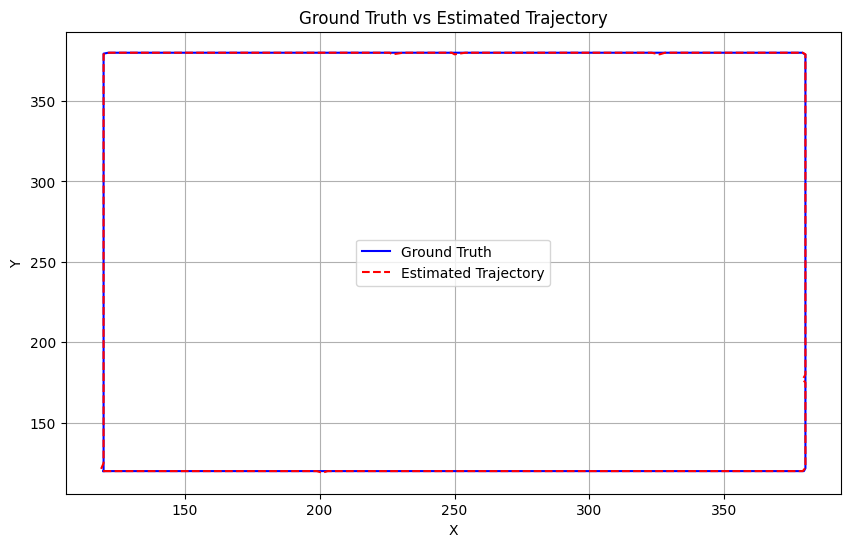

In [ ]:
def plot_trajectories(gt_trajectory, estimated_trajectory, title):
    """
    Plots the ground truth and estimated trajectories.

    Parameters:
        gt_trajectory (np.ndarray): Ground truth trajectory.
        estimated_trajectory (np.ndarray): Estimated trajectory.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(gt_trajectory[:, 0], gt_trajectory[:, 1], label='Ground Truth', color='blue')
    plt.plot(estimated_trajectory[:, 0], estimated_trajectory[:, 1], label='Estimated Trajectory', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the trajectories
plot_trajectories(gt_trajectory, estimated_trajectory, 'Ground Truth vs Estimated Trajectory')

Convert the ball tracking video into MP4 for demonstration purposes:

In [ ]:
!{convert_avi2mp4.format(input="tracking.avi", output="tracking.mp4")}

Converting 'tracking.avi' to 'tracking.mp4'...
Completed.


In [ ]:
Video('tracking.mp4', embed=True)

In [ ]:
gt_trajectory = cubic_spline_trajectory

generate_video('output_cubic_yellow_with_noise.avi', cubic_spline_trajectory, **video_opts, ball_color=BALL_COLOR_YELLOW, enable_cross_noise=True)

!{convert_avi2mp4.format(input="output_cubic_yellow_with_noise.avi", output="playback_yellow.mp4")}

Video('playback_yellow.mp4', embed=True)

Video saved as 'output_cubic_yellow_with_noise.avi'
Converting 'output_cubic_yellow_with_noise.avi' to 'playback_yellow.mp4'...
Completed.


In [ ]:
capture = cv2.VideoCapture('output_cubic_yellow_with_noise.avi')

width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
framerate = int(capture.get(cv2.CAP_PROP_FPS))

output_filename = 'tracking_yellow_with_fixed_info.avi'
fourcc = cv2.VideoWriter_fourcc(*'FFV1')
out = cv2.VideoWriter(output_filename, fourcc, framerate, (width, height))

lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])

estimated_trajectory = []

while True:
    status, frame = capture.read()

    if not status:
        break

    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(hsv_frame, lower_yellow, upper_yellow)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        min_contour_area = 100
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)

            binary_image = np.zeros_like(mask)
            cv2.drawContours(binary_image, [largest_contour], -1, 255, thickness=cv2.FILLED)

            moments_result = compute_moments(binary_image)
            centroid = moments_result['centroid']
            area = moments_result['area']

            if centroid:
                centroid_x, centroid_y = int(centroid[0]), int(centroid[1])
                cv2.circle(frame, (centroid_x, centroid_y), 5, (0, 255, 0), -1)
                estimated_trajectory.append((centroid_x, centroid_y))

                text_position = (10, 30)
                cv2.putText(frame, f"Position: ({centroid_x}, {centroid_y})", text_position,
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.putText(frame, f"Area: {area:.0f}", (10, 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    out.write(frame)

capture.release()
out.release()

print(f"Tracking video saved as {output_filename!r}")

Tracking video saved as 'tracking_yellow_with_fixed_info.avi'


MSE: 0.10175406347533378
RMSE: 0.3189891275190015


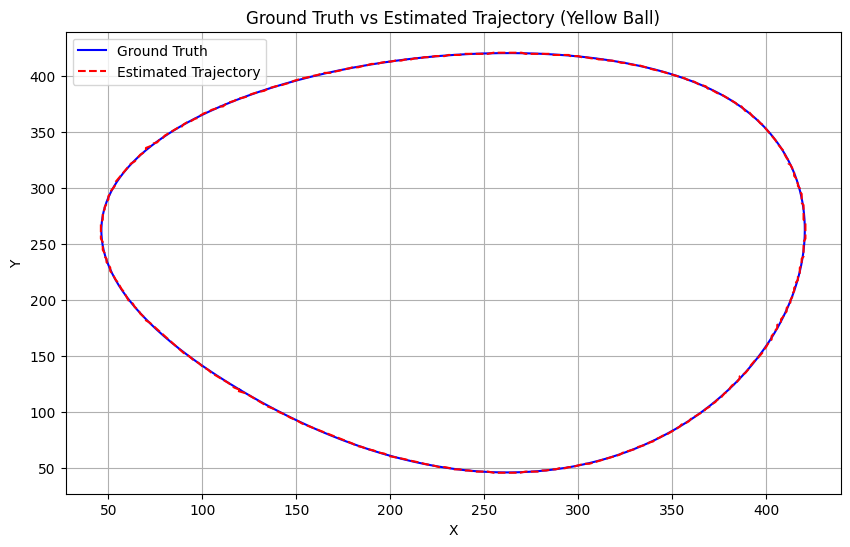

In [ ]:
estimated_trajectory = np.array(estimated_trajectory)

min_length = min(len(cubic_spline_trajectory), len(estimated_trajectory))
gt_trajectory = cubic_spline_trajectory[:min_length]
estimated_trajectory = estimated_trajectory[:min_length]

mse = compute_mse(gt_trajectory, estimated_trajectory)
rmse = compute_rmse(gt_trajectory, estimated_trajectory)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

plot_trajectories(gt_trajectory, estimated_trajectory, 'Ground Truth vs Estimated Trajectory (Yellow Ball)')

In [ ]:
!{convert_avi2mp4.format(input="tracking_yellow_with_fixed_info.avi", output="tracking_yellow_with_fixed_info.mp4")}

Video('tracking_yellow_with_fixed_info.mp4', embed=True)

Converting 'tracking_yellow_with_fixed_info.avi' to 'tracking_yellow_with_fixed_info.mp4'...
Completed.
